In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import pickle 
import regex as re
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import MiniBatchSparsePCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import copy
import scipy.stats
import collections
from math import isnan
from collections import ChainMap

In [2]:
def one_hot_encode_vital_status(dataframe):
    one_hot_encoded_df =pd.get_dummies(dataframe, columns=['vital_status'], prefix='onefor')
    one_hot_encoded_df.drop(columns = 'onefor_dead', inplace = True)
    return one_hot_encoded_df
    

In [3]:
def split_dataframe_by_drug(drugs_of_interest, dataframe):
    drug_dfs = {}
    for drug in drugs_of_interest:
        drug_dfs[drug]= dataframe [dataframe.standard_drugs==drug].drop(columns='standard_drugs')
    return drug_dfs

In [4]:
def batch_train_test_split(drug_dfs):
    split_drug_dfs ={}
    for key in drug_dfs:
        X_train, X_test, y_train, y_test= train_test_split(drug_dfs[key].drop('onefor_alive', axis = 1), drug_dfs[key].onefor_alive, random_state = 42)
        split_drug_dfs[key] = {}
        split_drug_dfs[key]['x_train'] = X_train
        split_drug_dfs[key]['x_test'] = X_test
        split_drug_dfs[key]['y_train'] = y_train
        split_drug_dfs[key]['y_test'] = y_test
    return split_drug_dfs

In [5]:
def run_logreg(split_drug_dfs, c):
    log_loss_metric = {}
    m_score = {}
    accuracy_scores = {}
    precision_scores = {}
    recall_scores = {}
    y_preds = {}
    evaluation_metrics = {}
    m= LogisticRegression(C=c, solver = 'lbfgs', max_iter = 1000)
    for key in split_drug_dfs:
            m.fit(split_drug_dfs[key]['x_train'], split_drug_dfs[key]['y_train'])
            mscore = m.score(split_drug_dfs[key]['x_train'],split_drug_dfs[key]['y_train'])
            m_score[key] = mscore
            y_pred = m.predict(split_drug_dfs[key]['x_test'])
            y_preds[key] = y_pred
            log_loss_score = log_loss(split_drug_dfs[key]['y_test'], y_pred)
            log_loss_metric[key] = log_loss_score
            accuracy = accuracy_score(split_drug_dfs[key]['y_test'], y_pred)
            accuracy_scores[key] = accuracy 
            precision =precision_score(split_drug_dfs[key]['y_test'], y_pred) 
            precision_scores[key]=precision
            recall = recall_score(split_drug_dfs[key]['y_test'], y_pred)
            recall_scores[key]= recall
    evaluation_metrics['score'] = m_score
    evaluation_metrics['log_loss'] = log_loss_metric
    evaluation_metrics['accuracy']= accuracy_scores
    evaluation_metrics['precision']= precision_scores
    evaluation_metrics['recall']= recall_scores
    evaluation_dataframe = pd.DataFrame(evaluation_metrics)
    return y_preds, m_score, log_loss_metric, evaluation_dataframe

In [6]:
def batch_min_max_scale (split_drug_dfs):
    #note that this cannot be used for PCA, as the mean must be centered at 0
    scaler = MinMaxScaler(feature_range=[0, 1])
    scaled_split_dfs=copy.deepcopy(split_drug_dfs)
    for key in split_drug_dfs:
        scaled_x_train = scaler.fit_transform(scaled_split_dfs[key]['x_train'])
        scaled_split_dfs[key]['x_train']=scaled_x_train
        scaled_x_test = scaler.transform(scaled_split_dfs[key]['x_test'])
        scaled_split_dfs[key]['x_test']= scaled_x_test
    return scaled_split_dfs 

In [7]:
def batch_standard_scale (split_drug_dfs):
    scaler = StandardScaler()
    scaled_split_dfs=copy.deepcopy(split_drug_dfs)
    for key in split_drug_dfs:
        scaled_x_train = scaler.fit_transform(scaled_split_dfs[key]['x_train'])
        scaled_split_dfs[key]['x_train']=scaled_x_train
        scaled_x_test = scaler.transform(scaled_split_dfs[key]['x_test'])
        scaled_split_dfs[key]['x_test']= scaled_x_test
    return scaled_split_dfs 

In [8]:
def batch_pca(scaled_split_dfs, threshold): 
    pca = PCA(threshold)
    pca_dfs = copy.deepcopy(scaled_split_dfs)
    pca_ncomponent = {}
    pca_explained_variance = {}
    pca_explained_variance_ratios = {}
    pca_components = {}
    pca_stats = {}
    for key in pca_dfs: 
        pca_x_train = pca.fit_transform(pca_dfs[key]['x_train'])
        pca_dfs[key]['x_train'] = pca_x_train
        pca_x_test = pca.transform(pca_dfs[key]['x_test'])
        pca_dfs[key]['x_test'] = pca_x_test
        pca_ncomponent[key]=pca.n_components_
        pca_components[key] = pca.components_
        pca_explained_var = pca.explained_variance_ratio_.cumsum().max().round(3)
        pca_explained_variance[key]= pca_explained_var
        pca_explained_variance_ratios[key]=pca.explained_variance_ratio_
    pca_stats['ncomponents']=pca_ncomponent
    pca_stats['explained_var']= pca_explained_variance
    pca_stats['components']=pca_components
    pca_stats['explained_var_ratio']=pca_explained_variance_ratios
    return pca_dfs, pca_stats


In [9]:
def batch_minibatch_sparse_pca (scaled_split_dfs,n_components, batch=50):
    sparse_pca_dfs = copy.deepcopy(scaled_split_dfs)
    sparse_mb_pca = MiniBatchSparsePCA(n_components = n_components, batch_size = batch, random_state=0)
    sparse_pca_ncomponents = {}
    sparse_pca_stats = {}
    for key in sparse_pca_dfs:     
        sparse_mb_pca.fit(sparse_pca_dfs[key]['x_train'])
        sparse_pca_x_train = sparse_mb_pca.transform(sparse_pca_dfs[key]['x_train'])
        sparse_pca_dfs[key]['x_train'] = sparse_pca_x_train
        sparse_pca_x_test = sparse_mb_pca.transform(scaled_split_dfs[key]['x_test'])
        sparse_pca_dfs[key]['x_test'] = sparse_pca_x_test
        sparse_pca_ncomponents[key]= sparse_pca_x_train.shape[1]
    sparse_pca_stats['ncomponents']=sparse_pca_ncomponents
    return sparse_pca_dfs, sparse_pca_stats

In [10]:
def pca_then_log_reg (scaled_split_dfs, threshold):
    pca_dfs, pca_stats = batch_pca(scaled_split_dfs, threshold)
    y_preds, m_score, log_loss_metric, evaluation_dataframe = run_logreg(pca_dfs, 0.01)
    return pca_dfs, evaluation_dataframe

In [11]:
def reduce_columns_by_stdev(split_dfs, remaining_percent_columns):
    stdev_limited_dfs = copy.deepcopy(split_dfs)
    for key in split_dfs:
        genes_sorted_by_stdev = split_drug_dfs[key]['x_test'].std(axis = 0).sort_values(ascending = False).index
        genes_to_keep = genes_sorted_by_stdev[0:(round(len(genes_sorted_by_stdev)*remaining_percent_columns))]
        stdev_limited_dfs[key]['x_test'] = split_drug_dfs[key]['x_test'][genes_to_keep]
        stdev_limited_dfs[key]['x_train'] = split_drug_dfs[key]['x_train'][genes_to_keep]
    return stdev_limited_dfs

In [12]:
def determine_correlation_coefficients(split_dfs):
    correlation_coefficients = {}
    for key in split_dfs:
        correlation_coefficients[key]={}
        for column in split_dfs[key]['x_train'].columns:
            corr_coeff = split_dfs[key]['x_train'][column].corr(split_dfs[key]['y_train'])
            correlation_coefficients[key][column]= corr_coeff
    return correlation_coefficients

In [13]:
def reduce_columns_by_correlation_coefficients(split_dfs, correlation_coefficients, remaining_percent_columns):
    corr_coeff_limited_dfs = copy.deepcopy(split_dfs)
    for key in correlation_coefficients: 
        sorted_correlation_coeff_per_drug  = sorted(correlation_coefficients[key].items(), key = lambda x: abs(x[1]), reverse = True)
        #drop all nan values 
        genes_in_order= [gene[0] for gene in sorted_correlation_coeff_per_drug if not isnan(gene[1])]
        genes_to_keep = genes_in_order[0:(round(len(sorted_correlation_coeff_per_drug)*remaining_percent_columns))]
        corr_coeff_limited_dfs[key]['x_test'] = split_drug_dfs[key]['x_test'][genes_to_keep]
        corr_coeff_limited_dfs[key]['x_train'] = split_drug_dfs[key]['x_train'][genes_to_keep]
    return corr_coeff_limited_dfs

In [14]:
def reduction_metric_optimization (split_dfs, reduction_strategy='nan',  percent_remaining_list=[1], correlation_coefficients='nan', scale = 'nan', pca = 'nan', threshold = [1], n_components = [5], c=0.001):
    evals_dataframes = {}
    pca_stats_total = {}
    for value in percent_remaining_list:
        if reduction_strategy == 'stdev':
            reduced_dataframe = reduce_columns_by_stdev(split_dfs, value)
        elif reduction_strategy =='corr':
            reduced_dataframe = reduce_columns_by_correlation_coefficients(split_dfs, correlation_coefficients, value)
        elif reduction_strategy == 'nan':
            reduced_dataframe=split_dfs
        if scale=='min_max':
            scaled_dataframe = batch_min_max_scale(reduced_dataframe)
            final_dataframe = scaled_dataframe
        elif scale == 'standard':
            scaled_dataframe = batch_standard_scale(reduced_dataframe)
            final_dataframe = scaled_dataframe
        elif scale == 'nan':
            final_dataframe = reduced_dataframe
        if pca == 'nan':
            y_preds, m_score, log_loss_metric, eval_dataframe = run_logreg(final_dataframe, c)
            evals_dataframes[f'{round(value*100)}_by_{reduction_strategy}_{scale}_scale'] = eval_dataframe
        elif pca == 'pca':
            for exp_variance in threshold: 
                pca_stats, eval_dataframe = pca_then_log_reg(final_dataframe, exp_variance)
                evals_dataframes[f'{round(value*100)}_by_{reduction_strategy}_{scale}_scale_pca_{exp_variance}'] = eval_dataframe
                pca_stats_total[f'{round(value*100)}_by_{reduction_strategy}_{scale}_scale_pca_{exp_variance}'] = pca_stats
        elif pca == 'sparse':
            for components in n_components:
                sparse_pca_dfs, sparse_pca_stats = batch_minibatch_sparse_pca (final_dataframe, n_components=components, batch=50)
                y_preds, m_score, log_loss_metric, eval_dataframe = run_logreg(sparse_pca_dfs, c)
                evals_dataframes[f'{round(value*100)}_by_{reduction_strategy}_{scale}_scale_sparse_pca_{components}'] = eval_dataframe
                pca_stats_total[f'{round(value*100)}_by_{reduction_strategy}_{scale}_scale_sparse_pca_{components}'] = sparse_pca_stats
    return evals_dataframes, pca_stats_total

In [15]:
def present_run_summary (all_results_dictionaries): 
    list_of_results_dfs=[]
    for eval_dict in all_results_dictionaries:
        list_of_results_dfs.append(pd.concat(eval_dict))
    summary_df = pd.concat(list_of_results_dfs)
    max_values = summary_df.unstack().max()
    best_methods = max_values.copy
    for combination in max_values.index: 
        best_methods[combination] = summary_df.unstack()[summary_df.unstack()[combination]
                        ==summary_df.unstack()[combination].max()]
    return best_methods

In [17]:
limited_data_0624= pickle.load(open('/Users/dinakats/Desktop/SPICED/final_proj_git_renew/Genetics-to-Therapuetics/limited_data_0624.pickle','rb'))

In [18]:
df = (one_hot_encode_vital_status(limited_data_0624))

In [19]:
df

,LINC02082,AC090241.2,RAB4B,ENSG00000273842,TIGAR,RNF44,NUP210P2,DNAH3,RPL23A,EHD4-AS1,...,CYP4F2,AL590824.1,AC010525.1,AC097724.1,PPP6R1,AL031666.1,ENSG00000280861,BATF3,standard_drugs,onefor_alive
0,0.000000,1.535474,1.432444,0.0,3.042826,13.129536,0.0,0.013725,143.973173,0.106523,...,0.000000,0.0,0.000000,0.032132,13.336782,0.287535,0.0,0.191725,sorafenib,0
1,0.049100,0.112411,3.236406,0.0,2.588924,12.977443,0.0,0.017477,102.836528,0.226077,...,3.666961,0.0,0.000000,0.081834,12.288496,0.337241,0.0,0.507561,sorafenib,0
2,0.022254,0.074107,1.745773,0.0,2.043631,6.803041,0.0,0.014786,74.978455,0.184439,...,25.374941,0.0,0.035828,0.037090,8.028534,0.148482,0.0,0.244604,oncophage vaccine,0
3,0.029526,0.000000,7.044585,0.0,3.217665,8.207564,0.0,0.009809,358.025155,0.163139,...,0.226847,0.0,0.095072,0.000000,5.626958,0.162237,0.0,3.121710,oncophage vaccine,0
4,0.759959,0.143791,1.059033,0.0,2.141863,27.879860,0.0,1.682061,110.210481,0.000000,...,0.546409,0.0,2.224577,0.000000,9.560019,0.271155,0.0,1.084819,interferon-alpha,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.000000,0.210632,2.128816,0.0,7.407418,13.665131,0.0,0.005377,39.174198,0.125188,...,0.000000,0.0,0.000000,0.037762,13.388848,0.489091,0.0,0.088942,ptk-zk,0
606,0.356159,0.004942,3.551915,0.0,1.020527,27.355877,0.0,0.092968,76.649951,0.098394,...,1.939607,0.0,0.688090,0.237440,14.124484,0.055914,0.0,0.643135,gemcitabine,0
607,0.356159,0.004942,3.551915,0.0,1.020527,27.355877,0.0,0.092968,76.649951,0.098394,...,1.939607,0.0,0.688090,0.237440,14.124484,0.055914,0.0,0.643135,avastin,0
608,0.356159,0.004942,3.551915,0.0,1.020527,27.355877,0.0,0.092968,76.649951,0.098394,...,1.939607,0.0,0.688090,0.237440,14.124484,0.055914,0.0,0.643135,il-2,0


In [20]:
drugs_of_interest = (df.standard_drugs.value_counts()[0:3].index.tolist())

In [21]:
drugs_of_interest

['gemcitabine', 'sunitinib', 'doxorubicin']

In [22]:
df_split = (split_dataframe_by_drug(drugs_of_interest, df))

In [43]:
genes = df_split['gemcitabine'].columns.to_list()[0:-1]

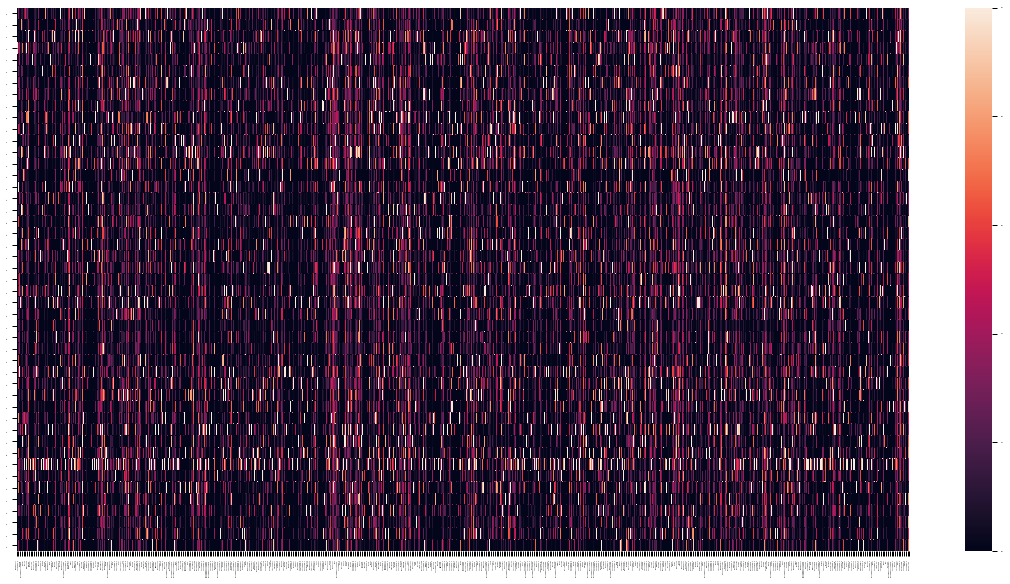

In [49]:
sns.set_context("paper", font_scale=0.2)
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(scaled_split_drugs['gemcitabine']['x_train'])
ax.set_xticklabels(genes)
plt.savefig('gem_heatmap.jpg', bbox_inches = 'tight',
    pad_inches = 0)

In [25]:
split_drug_dfs = batch_train_test_split(df_split)

In [26]:
scaled_split_drugs = batch_min_max_scale(split_drug_dfs)

In [28]:
scaled_split_drugs['gemcitabine']['x_train']

array([[0.        , 0.        , 0.18859605, ..., 0.60380515, 0.        ,
        0.31316037],
       [0.        , 0.        , 0.36069676, ..., 0.07317043, 0.        ,
        0.02387254],
       [0.82051815, 0.        , 0.11930367, ..., 0.02197645, 0.        ,
        0.14906898],
       ...,
       [0.17119789, 0.        , 0.15173348, ..., 0.0726006 , 0.        ,
        0.06097835],
       [0.        , 0.09014833, 0.11642435, ..., 0.06153342, 0.        ,
        0.24755261],
       [0.        , 0.        , 1.        , ..., 0.0505304 , 0.        ,
        0.74704878]])

In [23]:
all_metrics_concat = pd.concat(allmetrics.values(), keys =allmetrics.keys())

NameError: name 'allmetrics' is not defined

In [24]:
all_metrics_concat.unstack().sort_values(('accuracy', 'gemcitabine'), ascending=False).stack()

NameError: name 'all_metrics_concat' is not defined

In [25]:
evals_stdev_no_pca, no_pca = reduction_metric_optimization(split_drug_dfs, 
                                                      reduction_strategy='stdev',percent_remaining_list= [0.05, 0.1, 0.25, 0.5, 0.75])

In [26]:
evals_stdev_no_pca

{'5_by_stdev_nan_scale':                 score   log_loss  accuracy  precision    recall
 gemcitabine  1.000000  15.110965  0.562500   0.545455  0.750000
 sunitinib    0.977778  13.815777  0.600000   0.583333  0.875000
 doxorubicin  0.947368  18.597987  0.461538   0.500000  0.428571,
 '10_by_stdev_nan_scale':                 score   log_loss  accuracy  precision    recall
 gemcitabine  1.000000  15.110965  0.562500   0.545455  0.750000
 sunitinib    0.977778  13.815777  0.600000   0.583333  0.875000
 doxorubicin  0.947368  15.941097  0.538462   0.600000  0.428571,
 '25_by_stdev_nan_scale':                 score   log_loss  accuracy  precision    recall
 gemcitabine  1.000000  15.110965  0.562500   0.545455  0.750000
 sunitinib    0.977778  13.815777  0.600000   0.583333  0.875000
 doxorubicin  0.947368  15.941097  0.538462   0.600000  0.428571,
 '50_by_stdev_nan_scale':                 score   log_loss  accuracy  precision    recall
 gemcitabine  1.000000  15.110965  0.562500   0.54545

In [27]:
pd.concat(evals_stdev_no_pca)

score   log_loss  accuracy  precision  \
5_by_stdev_nan_scale  gemcitabine  1.000000  15.110965  0.562500   0.545455   
                      sunitinib    0.977778  13.815777  0.600000   0.583333   
                      doxorubicin  0.947368  18.597987  0.461538   0.500000   
10_by_stdev_nan_scale gemcitabine  1.000000  15.110965  0.562500   0.545455   
                      sunitinib    0.977778  13.815777  0.600000   0.583333   
                      doxorubicin  0.947368  15.941097  0.538462   0.600000   
25_by_stdev_nan_scale gemcitabine  1.000000  15.110965  0.562500   0.545455   
                      sunitinib    0.977778  13.815777  0.600000   0.583333   
                      doxorubicin  0.947368  15.941097  0.538462   0.600000   
50_by_stdev_nan_scale gemcitabine  1.000000  15.110965  0.562500   0.545455   
                      sunitinib    0.977778  13.815777  0.600000   0.583333   
                      doxorubicin  0.947368  15.941097  0.538462   0.600000   
75_by_stdev_nan_scale gemcitabine  1.000000  15.110965  0.562500   0.545455   
                      sunitinib    0.977778  13.815777  0.600000   0.583333   
                      doxorubicin  0.947368  15.941097  0.538462   0.600000   

                                     recall  
5_by_stdev_nan_scale  gemcitabine  0.750000  
                      sunitinib    0.875000  
                      doxorubicin  0.428571  
10_by_stdev_nan_scale gemcitabine  0.750000  
                      sunitinib    0.875000  
                      doxorubicin  0.428571  
25_by_stdev_nan_scale gemcitabine  0.750000  
                      sunitinib    0.875000  
                      doxorubicin  0.428571  
50_by_stdev_nan_scale gemcitabine  0.750000  
                      sunitinib    0.875000  
                      doxorubicin  0.428571  
75_by_stdev_nan_scale gemcitabine  0.750000  
                      sunitinib    0.875000  
                      doxorubicin  0.428571

In [28]:
correlation_coefficients = determine_correlation_coefficients(split_drug_dfs)

In [29]:
evals_corr_no_pca, nan = reduction_metric_optimization(split_drug_dfs, reduction_strategy = 'corr', percent_remaining_list= [0.05, 0.1, 0.25, 0.5, 0.75], correlation_coefficients=correlation_coefficients)

In [30]:
evals_corr_no_pca.keys()

dict_keys(['5_by_corr_nan_scale', '10_by_corr_nan_scale', '25_by_corr_nan_scale', '50_by_corr_nan_scale', '75_by_corr_nan_scale'])

In [31]:
corr_coeff_followed_by_pca_evals, corr_coeff_pca_stats = reduction_metric_optimization(split_drug_dfs, reduction_strategy='corr', percent_remaining_list= [0.05, 0.1, 0.25, 0.5, 0.75], correlation_coefficients=correlation_coefficients, scale = 'standard', pca = 'pca', threshold = [0.01, 0.2, 0.5, 0.9] )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision 

In [32]:
corr_coeff_followed_by_pca_evals

{'5_by_corr_standard_scale_pca_0.01':                 score   log_loss  accuracy  precision  recall
 gemcitabine  0.638298  15.110815  0.562500   0.600000   0.375
 sunitinib    0.711111  18.420681  0.466667   0.000000   0.000
 doxorubicin  0.552632  15.941343  0.538462   0.538462   1.000,
 '5_by_corr_standard_scale_pca_0.2':                 score   log_loss  accuracy  precision  recall
 gemcitabine  0.680851  17.269488  0.500000   0.500000    0.25
 sunitinib    0.711111  18.420681  0.466667   0.000000    0.00
 doxorubicin  0.552632  15.941343  0.538462   0.538462    1.00,
 '5_by_corr_standard_scale_pca_0.5':                 score   log_loss  accuracy  precision    recall
 gemcitabine  0.702128  15.110865  0.562500   0.571429  0.500000
 sunitinib    0.755556  18.420681  0.466667   0.000000  0.000000
 doxorubicin  0.631579  26.568659  0.230769   0.333333  0.428571,
 '5_by_corr_standard_scale_pca_0.9':                 score   log_loss  accuracy  precision    recall
 gemcitabine  0.957447 

In [33]:
#just pd.DataFrame doesn't work 
corr_coeff_pca= pd.concat(corr_coeff_followed_by_pca_evals)

In [34]:
corr_coeff_pca

score   log_loss  accuracy  \
5_by_corr_standard_scale_pca_0.01  gemcitabine  0.638298  15.110815  0.562500   
                                   sunitinib    0.711111  18.420681  0.466667   
                                   doxorubicin  0.552632  15.941343  0.538462   
5_by_corr_standard_scale_pca_0.2   gemcitabine  0.680851  17.269488  0.500000   
                                   sunitinib    0.711111  18.420681  0.466667   
                                   doxorubicin  0.552632  15.941343  0.538462   
5_by_corr_standard_scale_pca_0.5   gemcitabine  0.702128  15.110865  0.562500   
                                   sunitinib    0.755556  18.420681  0.466667   
                                   doxorubicin  0.631579  26.568659  0.230769   
5_by_corr_standard_scale_pca_0.9   gemcitabine  0.957447  15.110915  0.562500   
                                   sunitinib    0.911111  16.118096  0.533333   
                                   doxorubicin  0.868421  21.254816  0.384615   
10_by_corr_standard_scale_pca_0.01 gemcitabine  0.617021  17.269488  0.500000   
                                   sunitinib    0.711111  18.420681  0.466667   
                                   doxorubicin  0.552632  15.941343  0.538462   
10_by_corr_standard_scale_pca_0.2  gemcitabine  0.659574  19.428212  0.437500   
                                   sunitinib    0.711111  18.420681  0.466667   
                                   doxorubicin  0.552632  15.941343  0.538462   
10_by_corr_standard_scale_pca_0.5  gemcitabine  0.702128  15.110865  0.562500   
                                   sunitinib    0.755556  18.420681  0.466667   
                                   doxorubicin  0.578947  26.568659  0.230769   
10_by_corr_standard_scale_pca_0.9  gemcitabine  0.957447  15.110915  0.562500   
                                   sunitinib    0.888889  18.420681  0.466667   
                                   doxorubicin  0.868421  23.911645  0.307692   
25_by_corr_standard_scale_pca_0.01 gemcitabine  0.595745  15.110815  0.562500   
                                   sunitinib    0.711111  18.420681  0.466667   
                                   doxorubicin  0.552632  15.941343  0.538462   
25_by_corr_standard_scale_pca_0.2  gemcitabine  0.659574  19.428212  0.437500   
                                   sunitinib    0.711111  18.420681  0.466667   
                                   doxorubicin  0.552632  15.941343  0.538462   
25_by_corr_standard_scale_pca_0.5  gemcitabine  0.787234  15.110865  0.562500   
                                   sunitinib    0.733333  18.420681  0.466667   
                                   doxorubicin  0.578947  26.568659  0.230769   
25_by_corr_standard_scale_pca_0.9  gemcitabine  0.978723  19.428312  0.437500   
                                   sunitinib    0.933333  18.420734  0.466667   
                                   doxorubicin  0.921053  18.597864  0.461538   
50_by_corr_standard_scale_pca_0.01 gemcitabine  0.595745  12.952141  0.625000   
                                   sunitinib    0.711111  18.420681  0.466667   
                                   doxorubicin  0.552632  15.941343  0.538462   
50_by_corr_standard_scale_pca_0.2  gemcitabine  0.659574  17.269538  0.500000   
                                   sunitinib    0.711111  16.118096  0.533333   
                                   doxorubicin  0.552632  15.941343  0.538462   
50_by_corr_standard_scale_pca_0.5  gemcitabine  0.829787  15.110815  0.562500   
                                   sunitinib    0.755556  18.420681  0.466667   
                                   doxorubicin  0.578947  26.568659  0.230769   
50_by_corr_standard_scale_pca_0.9  gemcitabine  1.000000  15.110865  0.562500   
                                   sunitinib    0.933333  20.723426  0.400000   
                                   doxorubicin  0.921053  21.254755  0.384615   
75_by_corr_standard_scale_pca_0.01 gemcitabine  0.595745  15.110815  0.562500   
 

In [35]:
minibatch_bigfunc_evals, minibatch_bigfunc_pca_stats = reduction_metric_optimization(split_drug_dfs, reduction_strategy='nan',  scale = 'standard', pca = 'sparse', n_components=[15, 10, 5, 2])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
minibatch_bigfunc_evals

{'100_by_nan_standard_scale_sparse_pca_15':                 score   log_loss  accuracy  precision    recall
 gemcitabine  0.723404  10.793468  0.687500   0.714286  0.625000
 sunitinib    0.844444  20.723319  0.400000   0.000000  0.000000
 doxorubicin  0.710526  23.911645  0.307692   0.250000  0.142857,
 '100_by_nan_standard_scale_sparse_pca_10':                 score   log_loss  accuracy  precision    recall
 gemcitabine  0.723404  17.269488  0.500000   0.500000  0.250000
 sunitinib    0.755556  18.420681  0.466667   0.000000  0.000000
 doxorubicin  0.605263  23.911707  0.307692   0.333333  0.285714,
 '100_by_nan_standard_scale_sparse_pca_5':                 score   log_loss  accuracy  precision    recall
 gemcitabine  0.680851  15.110815  0.562500   0.600000  0.375000
 sunitinib    0.711111  18.420681  0.466667   0.000000  0.000000
 doxorubicin  0.552632  26.568659  0.230769   0.333333  0.428571,
 '100_by_nan_standard_scale_sparse_pca_2':                 score   log_loss  accuracy  pr

In [37]:
all_metrics = {**evals_stdev_no_pca, **evals_corr_no_pca, **corr_coeff_followed_by_pca_evals, **minibatch_bigfunc_evals}

In [38]:
all_metrics_df = pd.concat(all_metrics)

In [39]:
all_metrics_df.unstack()

score                        \
                                        gemcitabine sunitinib doxorubicin   
5_by_stdev_nan_scale                       1.000000  0.977778    0.947368   
10_by_stdev_nan_scale                      1.000000  0.977778    0.947368   
25_by_stdev_nan_scale                      1.000000  0.977778    0.947368   
50_by_stdev_nan_scale                      1.000000  0.977778    0.947368   
75_by_stdev_nan_scale                      1.000000  0.977778    0.947368   
5_by_corr_nan_scale                        1.000000  0.977778    0.947368   
10_by_corr_nan_scale                       1.000000  0.977778    0.947368   
25_by_corr_nan_scale                       1.000000  0.977778    0.947368   
50_by_corr_nan_scale                       1.000000  0.977778    0.947368   
75_by_corr_nan_scale                       1.000000  0.977778    0.947368   
5_by_corr_standard_scale_pca_0.01          0.638298  0.711111    0.552632   
5_by_corr_standard_scale_pca_0.2           0.680851  0.711111    0.552632   
5_by_corr_standard_scale_pca_0.5           0.702128  0.755556    0.631579   
5_by_corr_standard_scale_pca_0.9           0.957447  0.911111    0.868421   
10_by_corr_standard_scale_pca_0.01         0.617021  0.711111    0.552632   
10_by_corr_standard_scale_pca_0.2          0.659574  0.711111    0.552632   
10_by_corr_standard_scale_pca_0.5          0.702128  0.755556    0.578947   
10_by_corr_standard_scale_pca_0.9          0.957447  0.888889    0.868421   
25_by_corr_standard_scale_pca_0.01         0.595745  0.711111    0.552632   
25_by_corr_standard_scale_pca_0.2          0.659574  0.711111    0.552632   
25_by_corr_standard_scale_pca_0.5          0.787234  0.733333    0.578947   
25_by_corr_standard_scale_pca_0.9          0.978723  0.933333    0.921053   
50_by_corr_standard_scale_pca_0.01         0.595745  0.711111    0.552632   
50_by_corr_standard_scale_pca_0.2          0.659574  0.711111    0.552632   
50_by_corr_standard_scale_pca_0.5          0.829787  0.755556    0.578947   
50_by_corr_standard_scale_pca_0.9          1.000000  0.933333    0.921053   
75_by_corr_standard_scale_pca_0.01         0.595745  0.711111    0.552632   
75_by_corr_standard_scale_pca_0.2          0.659574  0.711111    0.552632   
75_by_corr_standard_scale_pca_0.5          0.808511  0.777778    0.578947   
75_by_corr_standard_scale_pca_0.9          1.000000  0.977778    0.947368   
100_by_nan_standard_scale_sparse_pca_15    0.723404  0.844444    0.710526   
100_by_nan_standard_scale_sparse_pca_10    0.723404  0.755556    0.605263   
100_by_nan_standard_scale_sparse_pca_5     0.680851  0.711111    0.552632   
100_by_nan_standard_scale_sparse_pca_2     0.702128  0.711111    0.526316   

                                           log_loss                         \
                                        gemcitabine  sunitinib doxorubicin   
5_by_stdev_nan_scale                      15.110965  13.815777   18.597987   
10_by_stdev_nan_scale                     15.110965  13.815777   15.941097   
25_by_stdev_nan_scale                     15.110965  13.815777   15.941097   
50_by_stdev_nan_scale                     15.110965  13.815777   15.941097   
75_by_stdev_nan_scale                     15.110965  13.815777   15.941097   
5_by_corr_nan_scale                       12.952241  13.815670   23.911645   
10_by_corr_nan_scale                      15.110915   4.605223   23.911584   
25_by_corr_nan_scale                      17.269638  13.815777   18.597987   
50_by_corr_nan_scale                      17.269588  16.118415   21.254816   
75_by_corr_nan_scale                      15.110965  13.815777   18.597987   
5_by_corr_standard_scale_pca_0.01         15.110815  18.420681   15.941343   
5_by_corr_standard_scale_pca_0.2          17.269488  18.420681   15.941343   
5_by_corr_standard_scale_pca_0.5          15.110865  18.420681   26.568659   
5_by_corr_standard_scale_pca_0.9          15.110915  16.118096   21.254816   
10_by_corr_standard_scale

In [64]:
evals_corr_no_pca

{'5_by_corr_nan_scale':                 score   log_loss  accuracy  precision    recall
 gemcitabine  1.000000  12.952241  0.625000      0.600  0.750000
 sunitinib    0.977778  13.815670  0.600000      0.625  0.625000
 doxorubicin  0.947368  23.911645  0.307692      0.250  0.142857,
 '10_by_corr_nan_scale':                 score   log_loss  accuracy  precision  recall
 gemcitabine  1.000000  15.110915  0.562500   0.555556   0.625
 sunitinib    0.977778   4.605223  0.866667   0.875000   0.875
 doxorubicin  0.947368  23.911584  0.307692   0.000000   0.000,
 '25_by_corr_nan_scale':                 score   log_loss  accuracy  precision    recall
 gemcitabine  1.000000  17.269638  0.500000   0.500000  0.625000
 sunitinib    0.977778  13.815777  0.600000   0.583333  0.875000
 doxorubicin  0.947368  18.597987  0.461538   0.500000  0.428571,
 '50_by_corr_nan_scale':                 score   log_loss  accuracy  precision    recall
 gemcitabine  1.000000  17.269588  0.500000   0.500000  0.500000


In [58]:
test_dict_list = [evals_stdev_no_pca, evals_corr_no_pca, corr_coeff_followed_by_pca_evals, minibatch_bigfunc_evals]

In [59]:
test_merge = (ChainMap(*test_dict_list))

In [74]:
all_test_df = pd.concat(test_merge.maps[0])

In [78]:
list_of_dfs=[]
for item in test_dict_list:
    list_of_dfs.append(pd.concat(item))

In [79]:
list_of_dfs[0]

score   log_loss  accuracy  precision  \
5_by_stdev_nan_scale  gemcitabine  1.000000  15.110965  0.562500   0.545455   
                      sunitinib    0.977778  13.815777  0.600000   0.583333   
                      doxorubicin  0.947368  18.597987  0.461538   0.500000   
10_by_stdev_nan_scale gemcitabine  1.000000  15.110965  0.562500   0.545455   
                      sunitinib    0.977778  13.815777  0.600000   0.583333   
                      doxorubicin  0.947368  15.941097  0.538462   0.600000   
25_by_stdev_nan_scale gemcitabine  1.000000  15.110965  0.562500   0.545455   
                      sunitinib    0.977778  13.815777  0.600000   0.583333   
                      doxorubicin  0.947368  15.941097  0.538462   0.600000   
50_by_stdev_nan_scale gemcitabine  1.000000  15.110965  0.562500   0.545455   
                      sunitinib    0.977778  13.815777  0.600000   0.583333   
                      doxorubicin  0.947368  15.941097  0.538462   0.600000   
75_by_stdev_nan_scale gemcitabine  1.000000  15.110965  0.562500   0.545455   
                      sunitinib    0.977778  13.815777  0.600000   0.583333   
                      doxorubicin  0.947368  15.941097  0.538462   0.600000   

                                     recall  
5_by_stdev_nan_scale  gemcitabine  0.750000  
                      sunitinib    0.875000  
                      doxorubicin  0.428571  
10_by_stdev_nan_scale gemcitabine  0.750000  
                      sunitinib    0.875000  
                      doxorubicin  0.428571  
25_by_stdev_nan_scale gemcitabine  0.750000  
                      sunitinib    0.875000  
                      doxorubicin  0.428571  
50_by_stdev_nan_scale gemcitabine  0.750000  
                      sunitinib    0.875000  
                      doxorubicin  0.428571  
75_by_stdev_nan_scale gemcitabine  0.750000  
                      sunitinib    0.875000  
                      doxorubicin  0.428571

In [81]:
test_summ = pd.concat(list_of_dfs)

In [82]:
test_summ

score   log_loss  \
5_by_stdev_nan_scale                   gemcitabine  1.000000  15.110965   
                                       sunitinib    0.977778  13.815777   
                                       doxorubicin  0.947368  18.597987   
10_by_stdev_nan_scale                  gemcitabine  1.000000  15.110965   
                                       sunitinib    0.977778  13.815777   
...                                                      ...        ...   
100_by_nan_standard_scale_sparse_pca_5 sunitinib    0.711111  18.420681   
                                       doxorubicin  0.552632  26.568659   
100_by_nan_standard_scale_sparse_pca_2 gemcitabine  0.702128  12.952141   
                                       sunitinib    0.711111  16.118096   
                                       doxorubicin  0.526316  15.941343   

                                                    accuracy  precision  \
5_by_stdev_nan_scale                   gemcitabine  0.562500   0.545455   
                                       sunitinib    0.600000   0.583333   
                                       doxorubicin  0.461538   0.500000   
10_by_stdev_nan_scale                  gemcitabine  0.562500   0.545455   
                                       sunitinib    0.600000   0.583333   
...                                                      ...        ...   
100_by_nan_standard_scale_sparse_pca_5 sunitinib    0.466667   0.000000   
                                       doxorubicin  0.230769   0.333333   
100_by_nan_standard_scale_sparse_pca_2 gemcitabine  0.625000   0.666667   
                                       sunitinib    0.533333   1.000000   
                                       doxorubicin  0.538462   0.538462   

                                                      recall  
5_by_stdev_nan_scale                   gemcitabine  0.750000  
                                       sunitinib    0.875000  
                                       doxorubicin  0.428571  
10_by_stdev_nan_scale                  gemcitabine  0.750000  
                                       sunitinib    0.875000  
...                                                      ...  
100_by_nan_standard_scale_sparse_pca_5 sunitinib    0.000000  
                                       doxorubicin  0.428571  
100_by_nan_standard_scale_sparse_pca_2 gemcitabine  0.500000  
                                       sunitinib    0.125000  
                                       doxorubicin  1.000000  

[102 rows x 5 columns]

In [88]:
test_summ['accuracy'].groupby(level=1).max()['doxorubicin']

0.5384615384615384

In [90]:
test_summ['accuracy'][test_summ['accuracy']==test_summ['accuracy'].groupby(level=1).max()['doxorubicin']]

10_by_stdev_nan_scale                   doxorubicin    0.538462
25_by_stdev_nan_scale                   doxorubicin    0.538462
50_by_stdev_nan_scale                   doxorubicin    0.538462
75_by_stdev_nan_scale                   doxorubicin    0.538462
5_by_corr_standard_scale_pca_0.01       doxorubicin    0.538462
5_by_corr_standard_scale_pca_0.2        doxorubicin    0.538462
10_by_corr_standard_scale_pca_0.01      doxorubicin    0.538462
10_by_corr_standard_scale_pca_0.2       doxorubicin    0.538462
25_by_corr_standard_scale_pca_0.01      doxorubicin    0.538462
25_by_corr_standard_scale_pca_0.2       doxorubicin    0.538462
50_by_corr_standard_scale_pca_0.01      doxorubicin    0.538462
50_by_corr_standard_scale_pca_0.2       doxorubicin    0.538462
75_by_corr_standard_scale_pca_0.01      doxorubicin    0.538462
75_by_corr_standard_scale_pca_0.2       doxorubicin    0.538462
100_by_nan_standard_scale_sparse_pca_2  doxorubicin    0.538462
Name: accuracy, dtype: float64

In [144]:
max_values_test = test_summ.unstack().max()

In [145]:
max_values_test

score      doxorubicin     0.947368
           gemcitabine     1.000000
           sunitinib       0.977778
log_loss   doxorubicin    26.568659
           gemcitabine    19.428312
           sunitinib      20.723426
accuracy   doxorubicin     0.538462
           gemcitabine     0.687500
           sunitinib       0.866667
precision  doxorubicin     0.600000
           gemcitabine     0.714286
           sunitinib       1.000000
recall     doxorubicin     1.000000
           gemcitabine     0.750000
           sunitinib       0.875000
dtype: float64

In [118]:
best_methods = test_summ.unstack()[test_summ.unstack()[('score','doxorubicin')]==test_summ.unstack()[('score','doxorubicin')].max()].index

In [119]:
best_methods

Index(['10_by_corr_nan_scale', '10_by_stdev_nan_scale', '25_by_corr_nan_scale',
       '25_by_stdev_nan_scale', '50_by_corr_nan_scale',
       '50_by_stdev_nan_scale', '5_by_corr_nan_scale', '5_by_stdev_nan_scale',
       '75_by_corr_nan_scale', '75_by_corr_standard_scale_pca_0.9',
       '75_by_stdev_nan_scale'],
      dtype='object')

In [124]:
max_values_test[('score','doxorubicin')]

TypeError: 'numpy.float64' object does not support item assignment

In [138]:
max_values_test[('score', 'doxorubicin')]=best_methods.to_list()


{('score', 'doxorubicin'): 'beep boop'}

In [143]:
max_values_test.unstack()

,doxorubicin,gemcitabine,sunitinib,,method
score,"[10_by_corr_nan_scale, 10_by_stdev_nan_scale, ...",1,0.977778,NaN,NaN
log_loss,26.5687,19.4283,20.7234,NaN,NaN
accuracy,0.538462,0.6875,0.866667,NaN,NaN
precision,0.6,0.714286,1,NaN,NaN
recall,1,0.75,0.875,NaN,NaN
method,NaN,NaN,NaN,5,NaN
"(score, doxorubicin)",NaN,NaN,NaN,NaN,5


In [95]:
test_summ.unstack()

score                        \
                                        doxorubicin gemcitabine sunitinib   
100_by_nan_standard_scale_sparse_pca_10    0.605263    0.723404  0.755556   
100_by_nan_standard_scale_sparse_pca_15    0.710526    0.723404  0.844444   
100_by_nan_standard_scale_sparse_pca_2     0.526316    0.702128  0.711111   
100_by_nan_standard_scale_sparse_pca_5     0.552632    0.680851  0.711111   
10_by_corr_nan_scale                       0.947368    1.000000  0.977778   
10_by_corr_standard_scale_pca_0.01         0.552632    0.617021  0.711111   
10_by_corr_standard_scale_pca_0.2          0.552632    0.659574  0.711111   
10_by_corr_standard_scale_pca_0.5          0.578947    0.702128  0.755556   
10_by_corr_standard_scale_pca_0.9          0.868421    0.957447  0.888889   
10_by_stdev_nan_scale                      0.947368    1.000000  0.977778   
25_by_corr_nan_scale                       0.947368    1.000000  0.977778   
25_by_corr_standard_scale_pca_0.01         0.552632    0.595745  0.711111   
25_by_corr_standard_scale_pca_0.2          0.552632    0.659574  0.711111   
25_by_corr_standard_scale_pca_0.5          0.578947    0.787234  0.733333   
25_by_corr_standard_scale_pca_0.9          0.921053    0.978723  0.933333   
25_by_stdev_nan_scale                      0.947368    1.000000  0.977778   
50_by_corr_nan_scale                       0.947368    1.000000  0.977778   
50_by_corr_standard_scale_pca_0.01         0.552632    0.595745  0.711111   
50_by_corr_standard_scale_pca_0.2          0.552632    0.659574  0.711111   
50_by_corr_standard_scale_pca_0.5          0.578947    0.829787  0.755556   
50_by_corr_standard_scale_pca_0.9          0.921053    1.000000  0.933333   
50_by_stdev_nan_scale                      0.947368    1.000000  0.977778   
5_by_corr_nan_scale                        0.947368    1.000000  0.977778   
5_by_corr_standard_scale_pca_0.01          0.552632    0.638298  0.711111   
5_by_corr_standard_scale_pca_0.2           0.552632    0.680851  0.711111   
5_by_corr_standard_scale_pca_0.5           0.631579    0.702128  0.755556   
5_by_corr_standard_scale_pca_0.9           0.868421    0.957447  0.911111   
5_by_stdev_nan_scale                       0.947368    1.000000  0.977778   
75_by_corr_nan_scale                       0.947368    1.000000  0.977778   
75_by_corr_standard_scale_pca_0.01         0.552632    0.595745  0.711111   
75_by_corr_standard_scale_pca_0.2          0.552632    0.659574  0.711111   
75_by_corr_standard_scale_pca_0.5          0.578947    0.808511  0.777778   
75_by_corr_standard_scale_pca_0.9          0.947368    1.000000  0.977778   
75_by_stdev_nan_scale                      0.947368    1.000000  0.977778   

                                           log_loss                         \
                                        doxorubicin gemcitabine  sunitinib   
100_by_nan_standard_scale_sparse_pca_10   23.911707   17.269488  18.420681   
100_by_nan_standard_scale_sparse_pca_15   23.911645   10.793468  20.723319   
100_by_nan_standard_scale_sparse_pca_2    15.941343   12.952141  16.118096   
100_by_nan_standard_scale_sparse_pca_5    26.568659   15.110815  18.420681   
10_by_corr_nan_scale                      23.911584   15.110915   4.605223   
10_by_corr_standard_scale_pca_0.01        15.941343   17.269488  18.420681   
10_by_corr_standard_scale_pca_0.2         15.941343   19.428212  18.420681   
10_by_corr_standard_scale_pca_0.5         26.568659   15.110865  18.420681   
10_by_corr_standard_scale_pca_0.9         23.911645   15.110915  18.420681   
10_by_stdev_nan_scale                     15.941097   15.110965  13.815777   
25_by_corr_nan_scale                      18.597987   17.269638  13.815777   
25_by_corr_standard_scale_pca_0.01        15.941343   15.110815  18.420681   
25_by_corr_standard_scale_pca_0.2         15.941343   19.428212  18.420681   
25_by_corr_standard_scale_pca_0.5         26.568659   15.110865  18.420681   
25_by_corr_standard_scale

In [266]:
func_test = present_run_summary(test_dict_list)

ValueError: Lengths must match to compare

In [271]:
summary_df.unstack()[summary_df.unstack()[test_combo]==1]

Empty DataFrame
Columns: [(score, doxorubicin), (score, gemcitabine), (score, sunitinib), (log_loss, doxorubicin), (log_loss, gemcitabine), (log_loss, sunitinib), (accuracy, doxorubicin), (accuracy, gemcitabine), (accuracy, sunitinib), (precision, doxorubicin), (precision, gemcitabine), (precision, sunitinib), (recall, doxorubicin), (recall, gemcitabine), (recall, sunitinib)]
Index: []

In [226]:
methods_dataframe = pd.DataFrame(func_test)

In [229]:
methods_dataframe['values']= max_values

In [275]:
methods_dataframe.loc[test_combo]['values']

'blah'

In [284]:
max_values = pd.DataFrame(summary_df.unstack().max(), columns=['values'])

In [287]:
max_values.loc[test_combo,'values']

0.9473684210526315

In [288]:
def present_run_summary (all_results_dictionaries): 
    list_of_results_dfs=[]
    for eval_dict in all_results_dictionaries:
        list_of_results_dfs.append(pd.concat(eval_dict))
    summary_df = pd.concat(list_of_results_dfs)
    max_values = pd.DataFrame(summary_df.unstack().max(), columns = ['values'])
    for combination in max_values.index: 
        best_method = summary_df.unstack()[summary_df.unstack()[combination]==max_values.loc[combination, 'values']].index.to_list()
        max_values.loc[combination, 'method'] = best_method
    return max_values

In [191]:
list_of_results_dfs = []
for eval_dict in test_dict_list:
    list_of_results_dfs.append(pd.concat(eval_dict))
summary_df = pd.concat(list_of_results_dfs)

In [192]:
summary_df

score   log_loss  \
5_by_stdev_nan_scale                   gemcitabine  1.000000  15.110965   
                                       sunitinib    0.977778  13.815777   
                                       doxorubicin  0.947368  18.597987   
10_by_stdev_nan_scale                  gemcitabine  1.000000  15.110965   
                                       sunitinib    0.977778  13.815777   
...                                                      ...        ...   
100_by_nan_standard_scale_sparse_pca_5 sunitinib    0.711111  18.420681   
                                       doxorubicin  0.552632  26.568659   
100_by_nan_standard_scale_sparse_pca_2 gemcitabine  0.702128  12.952141   
                                       sunitinib    0.711111  16.118096   
                                       doxorubicin  0.526316  15.941343   

                                                    accuracy  precision  \
5_by_stdev_nan_scale                   gemcitabine  0.562500   0.545455   
                                       sunitinib    0.600000   0.583333   
                                       doxorubicin  0.461538   0.500000   
10_by_stdev_nan_scale                  gemcitabine  0.562500   0.545455   
                                       sunitinib    0.600000   0.583333   
...                                                      ...        ...   
100_by_nan_standard_scale_sparse_pca_5 sunitinib    0.466667   0.000000   
                                       doxorubicin  0.230769   0.333333   
100_by_nan_standard_scale_sparse_pca_2 gemcitabine  0.625000   0.666667   
                                       sunitinib    0.533333   1.000000   
                                       doxorubicin  0.538462   0.538462   

                                                      recall  
5_by_stdev_nan_scale                   gemcitabine  0.750000  
                                       sunitinib    0.875000  
                                       doxorubicin  0.428571  
10_by_stdev_nan_scale                  gemcitabine  0.750000  
                                       sunitinib    0.875000  
...                                                      ...  
100_by_nan_standard_scale_sparse_pca_5 sunitinib    0.000000  
                                       doxorubicin  0.428571  
100_by_nan_standard_scale_sparse_pca_2 gemcitabine  0.500000  
                                       sunitinib    0.125000  
                                       doxorubicin  1.000000  

[102 rows x 5 columns]

In [193]:
max_values = summary_df.unstack().max()

In [194]:
max_values

score      doxorubicin     0.947368
           gemcitabine     1.000000
           sunitinib       0.977778
log_loss   doxorubicin    26.568659
           gemcitabine    19.428312
           sunitinib      20.723426
accuracy   doxorubicin     0.538462
           gemcitabine     0.687500
           sunitinib       0.866667
precision  doxorubicin     0.600000
           gemcitabine     0.714286
           sunitinib       1.000000
recall     doxorubicin     1.000000
           gemcitabine     0.750000
           sunitinib       0.875000
dtype: float64

In [195]:
best_methods = max_values.copy()

In [218]:
best_methods[test_combo]=summary_df.unstack()[summary_df.unstack()[test_combo]==max_values[test_combo]].index.to_list()

In [219]:
best_methods

score      doxorubicin    [10_by_corr_nan_scale, 10_by_stdev_nan_scale, ...
           gemcitabine                                                    1
           sunitinib                                               0.977778
log_loss   doxorubicin                                              26.5687
           gemcitabine                                              19.4283
           sunitinib                                                20.7234
accuracy   doxorubicin                                             0.538462
           gemcitabine                                               0.6875
           sunitinib                                               0.866667
precision  doxorubicin                                                  0.6
           gemcitabine                                             0.714286
           sunitinib                                                      1
recall     doxorubicin                                                    1
           g

In [197]:
test_combo= max_values.index[0]

In [202]:
max_values[test_combo]

0.9473684210526315

In [198]:
test_combo

('score', 'doxorubicin')

In [208]:
summary_df.unstack()[summary_df.unstack()[test_combo]==max_values[test_combo]].index.to_list()

['10_by_corr_nan_scale',
 '10_by_stdev_nan_scale',
 '25_by_corr_nan_scale',
 '25_by_stdev_nan_scale',
 '50_by_corr_nan_scale',
 '50_by_stdev_nan_scale',
 '5_by_corr_nan_scale',
 '5_by_stdev_nan_scale',
 '75_by_corr_nan_scale',
 '75_by_corr_standard_scale_pca_0.9',
 '75_by_stdev_nan_scale']

In [16]:
bop = 'bop'

In [17]:
bop.split(".")[0]

'bop'